<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предсказание-стоимости-жилья" data-toc-modified-id="Предсказание-стоимости-жилья-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предсказание стоимости жилья</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Трансформация-числовых-и-категориальных-признаков" data-toc-modified-id="Трансформация-числовых-и-категориальных-признаков-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Трансформация числовых и категориальных признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Обучение-модели-на-всех-данных-из-файла" data-toc-modified-id="Обучение-модели-на-всех-данных-из-файла-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Обучение модели на всех данных из файла</a></span></li><li><span><a href="#Обучение-модель-только-на-числовых-переменных" data-toc-modified-id="Обучение-модель-только-на-числовых-переменных-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Обучение модель только на числовых переменных</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Анализ результатов</a></span></li></ul></li></ul></div>

# Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

В колонках датасета содержатся следующие данные:
- longitude — широта;
- latitude — долгота;
- housing_median_age — медианный возраст жителей жилого массива;
- total_rooms — общее количество комнат в домах жилого массива;
- total_bedrooms — общее количество спален в домах жилого массива;
- population — количество человек, которые проживают в жилом массиве;
- households — количество домовладений в жилом массиве;
- median_income — медианный доход жителей жилого массива;
- median_house_value — медианная стоимость дома в жилом массиве;
- ocean_proximity — близость к океану.

## Подготовка данных

In [1]:
import pandas as pd 
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

RANDOM_SEED = 2022

spark = SparkSession.builder \
                    .master("local") \
                    .appName("Titanic - Logistic regression") \
                    .getOrCreate()

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder

In [2]:
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Выведем названия колонок и их тип данных в виде таблицы:

In [3]:
pandas_df_housing = pd.DataFrame(df_housing.dtypes, columns=['column', 'type']).head(10)
print(pandas_df_housing)

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


Выведем первые 10 строк датасета методом DataFrame API:

In [4]:
df_housing.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Выведем пропущенные значения в каждой колонке:

In [5]:
columns = df_housing.columns
check_val = [None, np.nan]

for column in columns:
    print(column, df_housing.where(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Для простоты удалим строки, в чьих данных есть пропущенные значения:

In [6]:
df_housing = df_housing.na.drop(subset='total_bedrooms')
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20433,20433,20433,20433,20433,20433,20433,20433,20433,20433
1,mean,-119.57068859198068,35.63322125972706,28.633093525179856,2636.5042333480155,537.8705525375618,1424.9469485635982,499.43346547251997,3.8711616013312273,206864.41315519012,None
2,stddev,2.003577890751096,2.1363476663779872,12.591805202182835,2185.269566977601,421.38507007403115,1133.2084897449597,382.2992258828481,1.899291249306247,115435.66709858322,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


Еще раз проверим пропуски:

In [7]:
columns = df_housing.columns
check_val = [None, np.nan]

for column in columns:
    print(column, df_housing.where(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


Найдём жилые массивы, в которых живут самые обеспеченные люди. Сгруппируем данные по столбцу с категориями удалённости от океана и посчитаем среднее значение медианного дохода в жилом массиве:

In [8]:
import seaborn as sns

df_wealthy = df_housing.groupBy('ocean_proximity').agg(F.avg('median_income').alias('avg_median_income')).toPandas()
df_wealthy 

,ocean_proximity,avg_median_income
0,ISLAND,2.744420
1,NEAR OCEAN,4.006374
2,NEAR BAY,4.175647
3,<1H OCEAN,4.231101
4,INLAND,3.210359


<AxesSubplot:xlabel='ocean_proximity', ylabel='avg_median_income'>

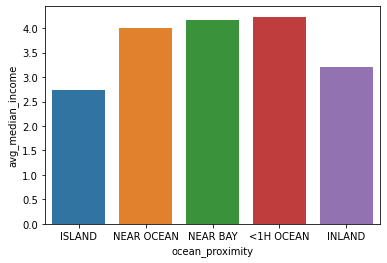

In [9]:
sns.barplot(data = df_wealthy, x='ocean_proximity', y='avg_median_income')

Люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива

Исследуем зависимость возраста жителей от удалённости жилого массива от океана. Сгруппируем данные по двум столбцам: медианный возраст жителей и удалённость от океана, а потом посчитаем сколько раз встречается то или иное медианное значение возраста в зависимости от удалённости от океана:

In [10]:
df_ages = df_housing.groupBy('housing_median_age','ocean_proximity').agg({'housing_median_age':'count'}).toPandas()
df_ages = df_ages.rename({'count(housing_median_age)':'count_households'},axis=1)
df_ages.head()

,housing_median_age,ocean_proximity,count_households
0,23.0,<1H OCEAN,194
1,31.0,NEAR BAY,41
2,11.0,<1H OCEAN,83
3,36.0,<1H OCEAN,473
4,10.0,INLAND,150


<AxesSubplot:xlabel='housing_median_age', ylabel='count_households'>

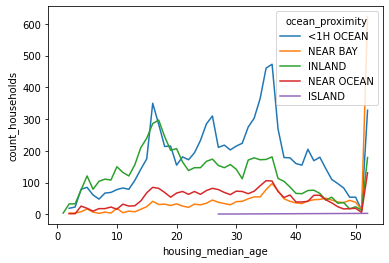

In [11]:
sns.lineplot(data=df_ages, 
    x='housing_median_age', 
    y= 'count_households', 
    hue='ocean_proximity'
)

По графику можно предположить, что люди до 20 лет чаще живут в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Старшие поколения предпочитают селиться в радиусе часа езды до океана и около залива.

Создадим несколько новых столбцов с признаками:

- Отношение количества комнат ***total_rooms*** к количеству домовладений ***households***. Назовём столбец ***rooms_per_household***.
- Отношение количества жителей ***population*** к количеству домовладений ***households***. Назовём столбец ***population_in_household***.
- Отношение количества спален ***total_bedrooms*** к общему количеству комнат ***total_rooms***. Назовём столбец ***bedroom_index***:

In [12]:
df_housing = df_housing.withColumn('rooms_per_household',F.col('total_rooms')/F.col('households')).withColumn('population_in_household',F.col('population')/F.col('households')).withColumn('bedroom_index',F.col('total_bedrooms')/F.col('total_rooms'))

df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



Были созданы новые колонки, которые могут быть подходящими признаками для модели машинного обучения.

Разделим колонки на два типа: числовые и текстовые, которые представляют категориальные данные

In [13]:
categorical_cols = ['ocean_proximity']
numerical_cols  = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',
                  'median_income', 'population_in_household' , 'rooms_per_household', 'bedroom_index']
target = 'median_house_value'

### Трансформация числовых и категориальных признаков

Трансформируем категориальные признаки с помощью трансформера StringIndexer:

df_housing = df_housing.drop('ocean_proximity') не сделала

In [14]:
indexer = StringIndexer(inputCol='ocean_proximity', 
                        outputCol='ocean_proximity_idx')
df_housing = indexer.fit(df_housing).transform(df_housing)
cols = [c for c in df_housing.columns for i in categorical_cols if (c.startswith(i))]
df_housing.select(cols).show(3) 

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
|       NEAR BAY|                3.0|
+---------------+-------------------+
only showing top 3 rows



Дополнительно сделаем OHE-кодирование для категорий:

In [15]:
encoder = OneHotEncoder(inputCol='ocean_proximity_idx', 
                        outputCol='ocean_proximity_ohe')
df_housing = encoder.fit(df_housing).transform(df_housing)
cols = [c for c in df_housing.columns for i in categorical_cols if (c.startswith(i))]
df_housing.select(cols).show(3) 

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



Финальный шаг преобразований — это объединение признаков в один вектор, с которым ML-алгоритм умеет работать:

In [16]:
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                        outputCol='categorical_features')
df_housing = categorical_assembler.transform(df_housing) 

Для числовых признаков тоже нужна трансформация — шкалирование значений — чтобы сильные выбросы не смещали предсказания модели

In [17]:
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                      outputCol='numerical_features')
df_housing = numerical_assembler.transform(df_housing)

In [18]:
standardScaler = StandardScaler(inputCol='numerical_features',
                                outputCol='numerical_features_scaled')
df_housing = standardScaler.fit(df_housing).transform(df_housing) 

Посмотрим что получилось:

In [19]:
print(df_housing.columns)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity', 'rooms_per_household', 'population_in_household', 'bedroom_index', 'ocean_proximity_idx', 'ocean_proximity_ohe', 'categorical_features', 'numerical_features', 'numerical_features_scaled']


Финальный шаг — собрать трансформированные категорийные и числовые признаки с помощью VectorAssembler:

In [20]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 
df_housing = final_assembler.transform(df_housing)
df_housing.select(all_features).show(3)

+--------------------+-------------------------+
|categorical_features|numerical_features_scaled|
+--------------------+-------------------------+
|       (4,[3],[1.0])|     [-61.005863841998...|
|       (4,[3],[1.0])|     [-61.000872770752...|
|       (4,[3],[1.0])|     [-61.010854913244...|
+--------------------+-------------------------+
only showing top 3 rows



In [21]:
df = df_housing.select(['features','median_house_value'])
df.show(3)

+--------------------+------------------+
|            features|median_house_value|
+--------------------+------------------+
|[0.0,0.0,0.0,1.0,...|          452600.0|
|[0.0,0.0,0.0,1.0,...|          358500.0|
|[0.0,0.0,0.0,1.0,...|          352100.0|
+--------------------+------------------+
only showing top 3 rows



In [22]:
df_numerical = df_housing.select(['numerical_features_scaled','median_house_value'])
df_numerical.show(3)

+-------------------------+------------------+
|numerical_features_scaled|median_house_value|
+-------------------------+------------------+
|     [-61.005863841998...|          452600.0|
|     [-61.000872770752...|          358500.0|
|     [-61.010854913244...|          352100.0|
+-------------------------+------------------+
only showing top 3 rows



### Вывод

- Проверили пропуски (найдено 207 пропусков в столбец total_bedrooms) и для простоты удалили строки, в чьих данных есть пропущенные значения
- Нашли жилые массивы, в которых живут самые обеспеченные люди и сгруппировали данные по столбцу с категориями удалённости от океана и посчитаем среднее значение медианного дохода в жилом массиве. На основе полученных данных можно сделать вывод, что люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива
- Исследовали зависимость возраста жителей от удалённости жилого массива от океана и сгруппировали данные по двум столбцам: медианный возраст жителей и удалённость от океана, а потом посчитали сколько раз встречается то или иное медианное значение возраста в зависимости от удалённости от океана. Построили график, по которому можно предположить, что люди до 20 лет чаще живут в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Старшие поколения предпочитают селиться в радиусе часа езды до океана и около залива.
- Создали несколько новых столбцов с признаками:
  - Отношение количества комнат total_rooms к количеству домовладений households. Назовём столбец rooms_per_household.
  - Отношение количества жителей population к количеству домовладений households. Назовём столбец population_in_household.
  - Отношение количества спален total_bedrooms к общему количеству комнат total_rooms. Назовём столбец bedroom_index

## Обучение моделей

### Разделение на выборки

Разделяем наш датасет на две части — выборку для обучения и выборку для тестирования качества модели.

In [23]:
df_train, df_test = df.randomSplit([.7,.3], seed=RANDOM_SEED)
print(df_train.count(), df_test.count())

14261 6172


In [24]:
df_num_train, df_num_test = df_numerical.randomSplit([.7,.3], seed=RANDOM_SEED)
print(df_num_train.count(), df_num_test.count())

14261 6172


### Обучение модели на всех данных из файла

In [25]:
lr = LinearRegression(featuresCol = 'features',labelCol='median_house_value', maxIter=10, regParam=0.2, elasticNetParam=0.6)
lr_model = lr.fit(df_train)

22/07/21 18:52:15 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/07/21 18:52:15 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Подведем итог модели по набору обучающих данных и распечатаем некоторые показатели:

In [26]:
training_summary = lr_model.summary

In [27]:
print("RMSE на тренировочных данных: %f" % training_summary.rootMeanSquaredError)
print("R2 на тренировочных данных: %f" % training_summary.r2)
print("MAE на тренировочных данных: %f" % training_summary.meanAbsoluteError)

RMSE на тренировочных данных: 69232.061904
R2 на тренировочных данных: 0.645924
MAE на тренировочных данных: 49618.556315


RMSE измеряет разницу между прогнозируемыми значениями по модели и фактическими значениями. Однако одно только RMSE не имеет смысла, пока мы не сравним с фактическим значением «median_house_value», таким как среднее, минимальное и максимальное

In [28]:
df_train.describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             14261|
|   mean|206896.54919009889|
| stddev|116352.05742458423|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



После такого сравнения наша RMSE выглядит довольно хорошо.

In [29]:
lr_predictions = lr_model.transform(df_test)
lr_predictions.select('prediction','median_house_value','features').show(5)
lr_evaluator = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='median_house_value',metricName='r2')
print("R2 на тестовых данных = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------------+--------------------+
|        prediction|median_house_value|            features|
+------------------+------------------+--------------------+
| 212349.5598108532|          414700.0|[0.0,0.0,0.0,0.0,...|
|236654.78975767049|          300000.0|[0.0,0.0,0.0,0.0,...|
| 347450.7861588105|          414300.0|[0.0,0.0,0.0,1.0,...|
| 404807.2321020077|          397300.0|[0.0,0.0,0.0,1.0,...|
|321837.55674396583|          285600.0|[0.0,0.0,0.0,1.0,...|
+------------------+------------------+--------------------+
only showing top 5 rows

R2 на тестовых данных = 0.640734


In [30]:
test_result = lr_model.evaluate(df_test)
print("Среднеквадратическая ошибка (RMSE) на тестовой выборке = %g" % test_result.rootMeanSquaredError)

Среднеквадратическая ошибка (RMSE) на тестовой выборке = 67904.6


In [31]:
lr_evaluator_mae = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='median_house_value',metricName='mae')
print("MAE на тестовых данных = %g" % lr_evaluator_mae.evaluate(lr_predictions))

MAE на тестовых данных = 48846.5


### Обучение модель только на числовых переменных

In [32]:
lr_num = LinearRegression(featuresCol = 'numerical_features_scaled', labelCol='median_house_value', maxIter=10, regParam=0.5, elasticNetParam=0.9)
lr_model_num = lr_num.fit(df_num_train)

In [33]:
training_summary_num = lr_model_num.summary

In [34]:
print("RMSE: %f" % training_summary_num.rootMeanSquaredError)

RMSE: 68602.641323


Так же сравним RMSE с фактическим значением «median_house_value»:

In [35]:
df_num_train.describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             14261|
|   mean| 206620.9837318561|
| stddev|115345.73822991732|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



In [36]:
print("R2 на тренировочных данных: %f" % training_summary_num.r2)

R2 на тренировочных данных: 0.646240


R2 = 0,63 указывает, что в нашей модели приблизительно 63% изменчивости в «median_house_value» можно объяснить с помощью модели

In [37]:
print("MAE на тренировочных данных: %f" % training_summary_num.meanAbsoluteError)

MAE на тренировочных данных: 49709.571103


In [38]:
lr_predictions_num = lr_model_num.transform(df_num_test)
lr_predictions_num.select('prediction','median_house_value','numerical_features_scaled').show(5)
lr_evaluator_num = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='median_house_value',metricName='r2')
print("R2 на тестовых данных = %g" % lr_evaluator_num.evaluate(lr_predictions_num))

+------------------+------------------+-------------------------+
|        prediction|median_house_value|numerical_features_scaled|
+------------------+------------------+-------------------------+
| 60537.04018135602|           85800.0|     [-62.039015589956...|
| 99216.59990670532|          103600.0|     [-62.039015589956...|
|187427.58209269494|          106700.0|     [-62.004078091233...|
| 186524.0131709478|           50800.0|     [-62.004078091233...|
| 124958.9454363212|           58100.0|     [-61.994095948741...|
+------------------+------------------+-------------------------+
only showing top 5 rows

R2 на тестовых данных = 0.638873


In [39]:
test_result_num = lr_model_num.evaluate(df_num_test)
print("Среднеквадратическая ошибка (RMSE) на тестовых данных = %g" % test_result_num.rootMeanSquaredError)

Среднеквадратическая ошибка (RMSE) на тестовых данных = 69493.3


In [40]:
lr_evaluator_num_mae = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='median_house_value',metricName='mae')
print("MAE на тестовых данных = %g" % lr_evaluator_num_mae.evaluate(lr_predictions_num))

MAE на тестовых данных = 50487.7


### Вывод

**При построении модели линейной регрессии на всех данных были получены следующие результаты**:
- RMSE
  - на тренировочных данных = 69154
  - на тестовой выборке = 69323.1
- R2 
  - на тренировочных данных = 0.643696
  - на тестовых данных = 0.633223
- MAE 
  - на тренировочных данных: 50145.091148
  - на тестовых данных = 49831.3

**При построении модели линейной регрессии только на числовых данных были получены следующие результаты**:
- RMSE
  - на обучающих данных = 70385.273101
  - на тестовых данных = 67125.5
- R2 
  - на тренировочных данных = 0.631557
  - на тестовых данных = 0.64633
- MAE 
  - на тренировочных данных: 51134.088578
  - на тестовых данных = 49453.5

## Анализ результатов

**На основе полученных данных можно сделать вывод**:
- люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива
- люди до 20 лет чаще живут в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана
- старшие поколения предпочитают селиться в радиусе часа езды до океана и около залива


**При построении модели линейной регрессии на всех данных были получены следующие результаты**:
- RMSE
  - на тренировочных данных = 69154
  - на тестовой выборке = 69323.1
- R2 
  - на тренировочных данных = 0.643696
  - на тестовых данных = 0.633223
- MAE 
  - на тренировочных данных: 50145.091148
  - на тестовых данных = 49831.3

**При построении модели линейной регрессии только на числовых данных были получены следующие результаты**:
- RMSE
  - на обучающих данных = 70385.273101
  - на тестовых данных = 67125.5
- R2 
  - на тренировочных данных = 0.631557
  - на тестовых данных = 0.64633
- MAE 
  - на тренировочных данных: 51134.088578
  - на тестовых данных = 49453.5